# Motivation

Purpose of this training task is to predict next 7 days of claims.

# Libraries

In [1]:
from itertools import product

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import MAE, QuantileLoss

from sklearn.model_selection import train_test_split

import torch

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import (
    adjust_column_names)

# Data Import

In [2]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocess

In [3]:
prep_data = source_data.copy()

## Adjust column names

In [4]:
prep_data = adjust_column_names(prep_data)

## Calculate monthly claims

In [5]:
prep_data = prep_data\
    .groupby(['date'])\
    .agg(
        sum_of_claims=pd.NamedAgg('claim_amount', 'sum'))\
    .reset_index()

prep_data.loc[:, 'group_idx'] = 1

## Calculate date features

In [6]:
prep_data.loc[:, 'day_of_week'] = prep_data.loc[:, 'date'].dt.dayofweek.astype(str)
prep_data.loc[:, 'day'] = prep_data.loc[:, 'date'].dt.day.astype(str)
prep_data.loc[:, 'month'] = prep_data.loc[:, 'date'].dt.month.astype(str)
prep_data.loc[:, 'year'] = prep_data.loc[:, 'date'].dt.year.astype(str)
prep_data.loc[:, 'yyyymm'] = prep_data.loc[:, 'date'].dt.strftime('%Y%m')

## Add time index

In [7]:
prep_data.loc[:, 'temp_1'] = (prep_data.loc[:, 'date'] - prep_data.loc[:, 'date'].min())

prep_data.loc[:, 'time_idx'] = (prep_data.loc[:, 'temp_1'].dt.days) + 1

prep_data.drop(['temp_1'], axis=1, inplace=True)

In [8]:
prep_data.loc[:, 'sum_of_claims_log'] = np.log(prep_data.loc[:, 'sum_of_claims'] + 1)

# Analysis

## Create datasets

In [9]:
max_prediction_length = 7
max_encoder_length = 14

all_idx = prep_data.time_idx.unique()
train_idx, test_idx = train_test_split(all_idx, test_size=0.15, shuffle=False)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, shuffle=False)

all_dataset = TimeSeriesDataSet(
    prep_data,
    time_idx='time_idx',
    target='sum_of_claims',
    group_ids=['group_idx'],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_reals=[],
    time_varying_known_categoricals=['year', 'month', 'day', 'day_of_week'],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['sum_of_claims_log'],
    target_normalizer=TorchNormalizer(),
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=True)

train_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @train_idx'),
    stop_randomization=True)

val_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @val_idx'),
    stop_randomization=True)

test_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @test_idx'),
    stop_randomization=True)\

batch_size = 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=len(test_dataset), num_workers=4)

## Baseline model

In [10]:
baseline_model = Baseline()
baseline_predictions = baseline_model.predict(test_dataloader, return_y=True)
mae_baseline = MAE()(baseline_predictions.output, baseline_predictions.y).item()

print(f'Mean absolute error of baseline model: {mae_baseline}')

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean absolute error of baseline model: 13170.099609375


## Temporal fusion transformer model

In [11]:
HIDDEN_SIZE=4
ATTENTION_HEAD_SIZE=4
DROPOUT_RATE=0.05
HIDDEN_CONTINOUS_SIZE=4

### Training

In [12]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=False, mode='min')

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='gpu',
    enable_model_summary=True,
    gradient_clip_val=0.25,
    callbacks=[early_stop_callback])

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    output_size=1,
    learning_rate=0.001,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT_RATE,
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,
    loss=MAE(),
    log_interval=10,
    optimizer='Adam',
    reduce_on_plateau_patience=4)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | loggi

Number of parameters in network: 2.0k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
# calcualte mean absolute error on validation set
tft_predictions = tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator='gpu'))
mae_tft = MAE()(tft_predictions.output, tft_predictions.y).item()

print(f'mean absolute error of tft model: {mae_tft}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean absolute error of tft model: 11938.9111328125


In [14]:
mae_tft = MAE()(tft_predictions.output, tft_predictions.y).item()

## Test the model

5 use-cases from the unseen test dataset is plotted.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


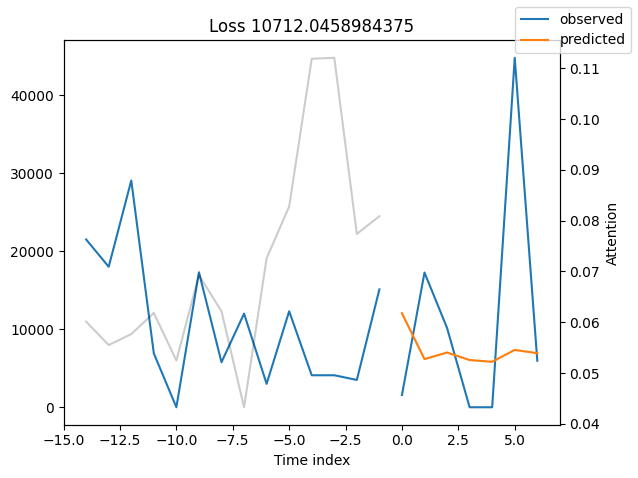

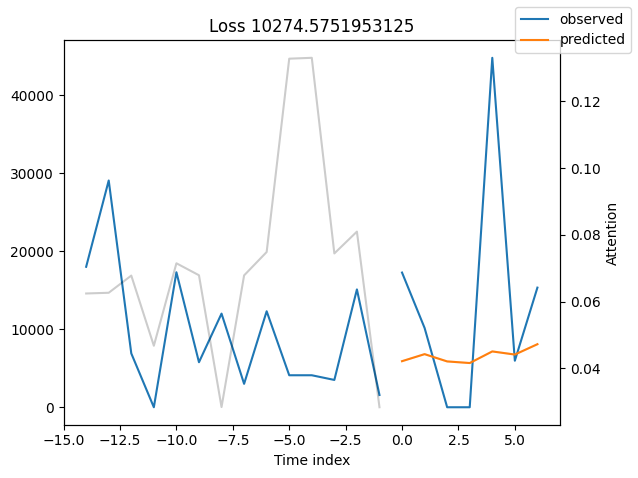

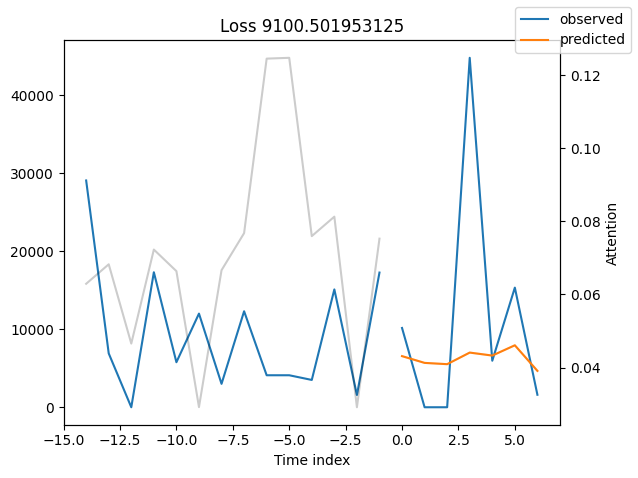

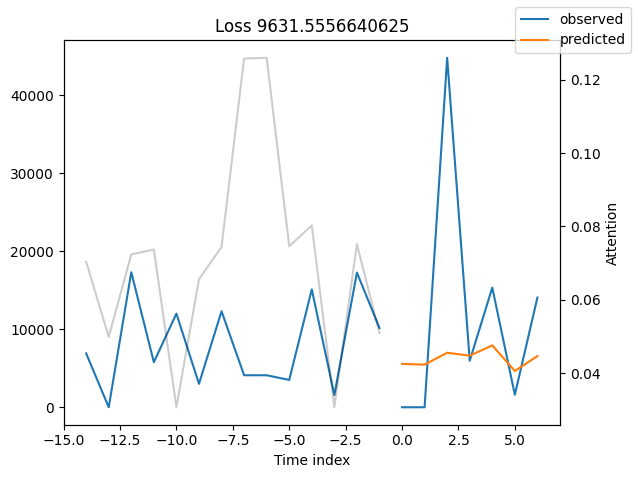

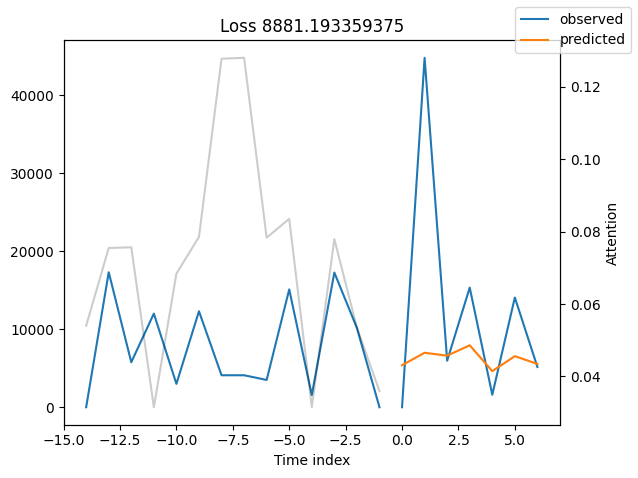

In [15]:
raw_predictions = tft.predict(test_dataloader, mode='raw', return_x=True)

for idx in range(5):
    tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=idx,
        add_loss_to_title=True)

plt.tight_layout()

# Interpretation

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

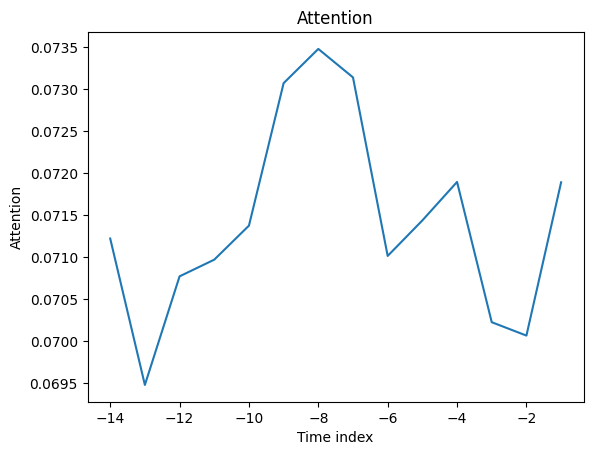

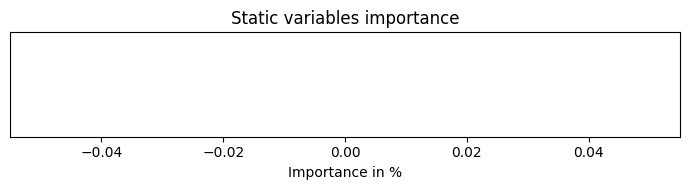

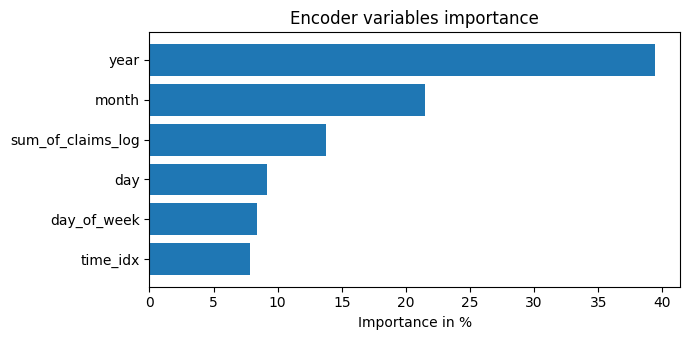

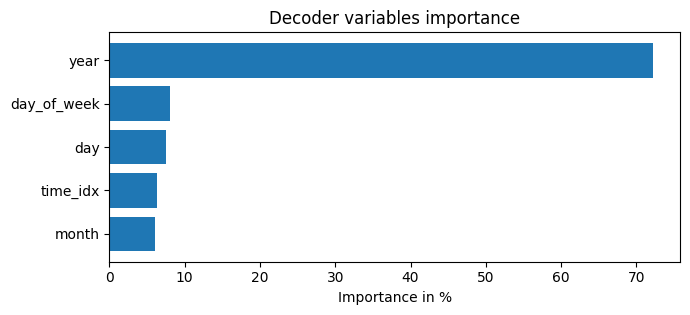

In [16]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="mean")
tft.plot_interpretation(interpretation)

# Discussion

* Model can't predict the peak values and zero values. Target variables should be pre-processed.
* More sophisticated pre-trained models could be used.
* Hyperparameter tuning should be applied.
* 7 days lookback has impact on forecasting next day.